In [31]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import data_visualization as dv
from copy import deepcopy
import time
from pathlib import Path
import pandas as pd
from IPython.display import display
from scipy.stats import iqr

import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
import Statistics as st
import loss_functions as lf
from matplotlib.animation import FuncAnimation
import constants
import data_visualization as dv
import model_helper_functions as mhf
from initializer import InitialThangs
it = InitialThangs("Exp1")
wheel = dv.ColorWheel()
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')

In [33]:
#* Import parameters used 
with open(constants.MODEL_INPUT_PATH / 'bootstrap_parameter_distribution.pkl','rb') as f:
    parameter_distribution = dill.load(f)    
with open(constants.MODEL_INPUT_PATH / 'bootstrap_results.pkl','rb') as f:
    results = dill.load(f)    
with open(constants.MODEL_INPUT_PATH / 'participant_ids.pkl','rb') as f:
    participant_ids = dill.load(f)

#* Import model data frames
model_description_paths = list(Path(constants.MODELS_PATH / "knockout_models").glob("Exp1_bootstrapped_model_descriptions*"))
model_parameter_paths = list(Path(constants.MODELS_PATH / "knockout_models").glob("Exp1_bootstrapped_model_parameters*"))
df_description = pd.read_pickle(model_description_paths[-1])
df_parameter = pd.read_pickle(model_parameter_paths[-1])

In [34]:
parameter_columns = [c for c in df_description.columns if c.startswith("Known")]
df_rows = []
for column in parameter_columns:
    new_df = df_description.query(f"{column} == False")
    avg_loss = new_df['Loss'].mean()
    df_rows.append({"unknown_input":column.lstrip("Known_"),
                    "average_loss":avg_loss})
df_summary = pd.DataFrame(df_rows)

In [35]:
df_summary

,unknown_input,average_loss
0,RT,22.992216
1,RT_SD,8.366592
2,MT,19.267334
3,MT_SD,8.331946
4,Timing_SD,4.351944
5,Electromechanical,8.146705
6,Electromechanical_SD,8.199608


In [36]:

# TODO Run regular model on bootstrapped parameters 


# Average Loss

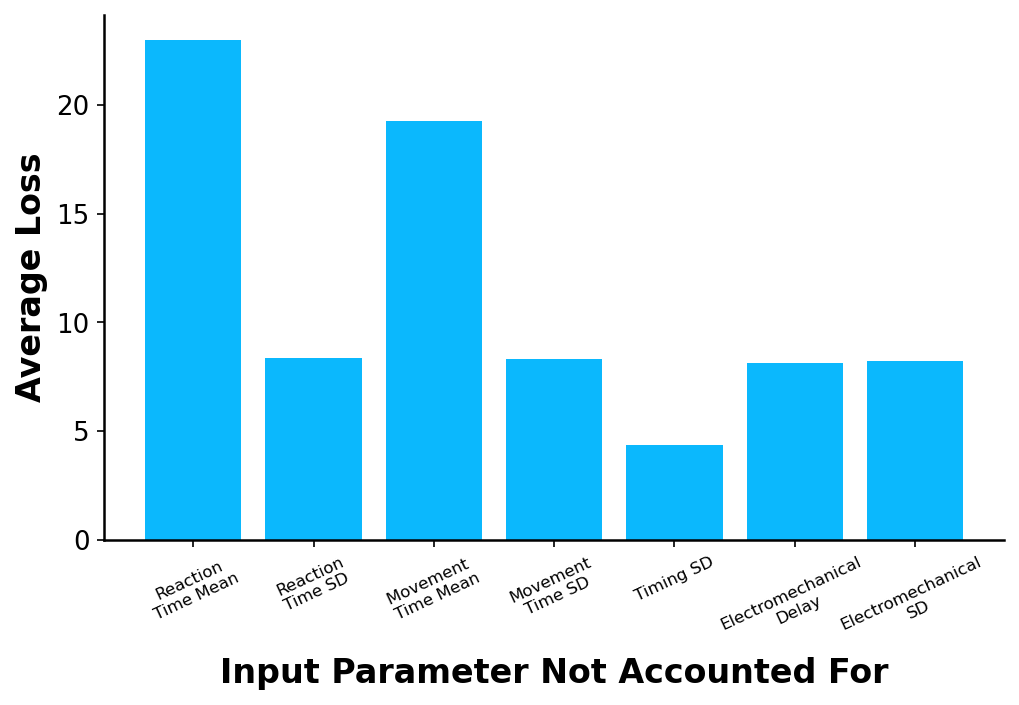

In [37]:
xticklabs = ["Reaction\nTime Mean", "Reaction\nTime SD",
             "Movement \nTime Mean", "Movement\nTime SD",
             "Timing SD",
             "Electromechanical\nDelay", "Electromechanical\nSD"]

fig = dv.Figure()
ax = fig.add_panel((0.5, 0, 6, 3.5))
xlocs = np.arange(0,len(df_summary),1)
ax.bar(xlocs,df_summary["average_loss"])
ax.set_xticks(xlocs)
ax.set_xticklabels(xticklabs,fontsize=8,rotation=25)
ax.set_xlabel("Input Parameter Not Accounted For")
ax.set_ylabel("Average Loss")
fig.remove_figure_borders()
plt.show()


# Parameter Distributions

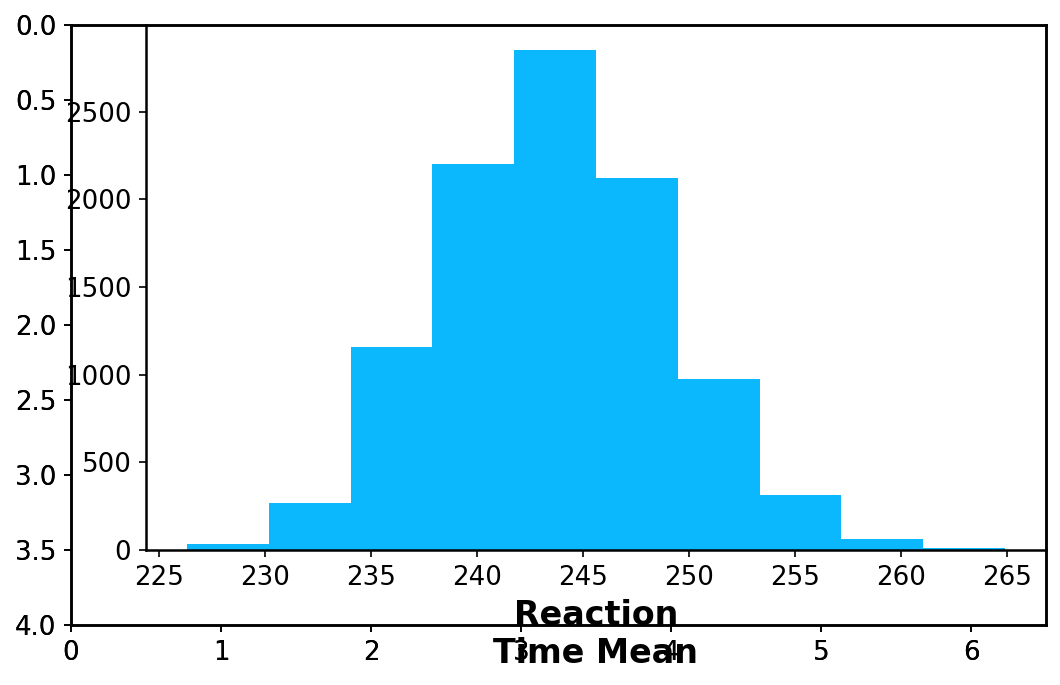

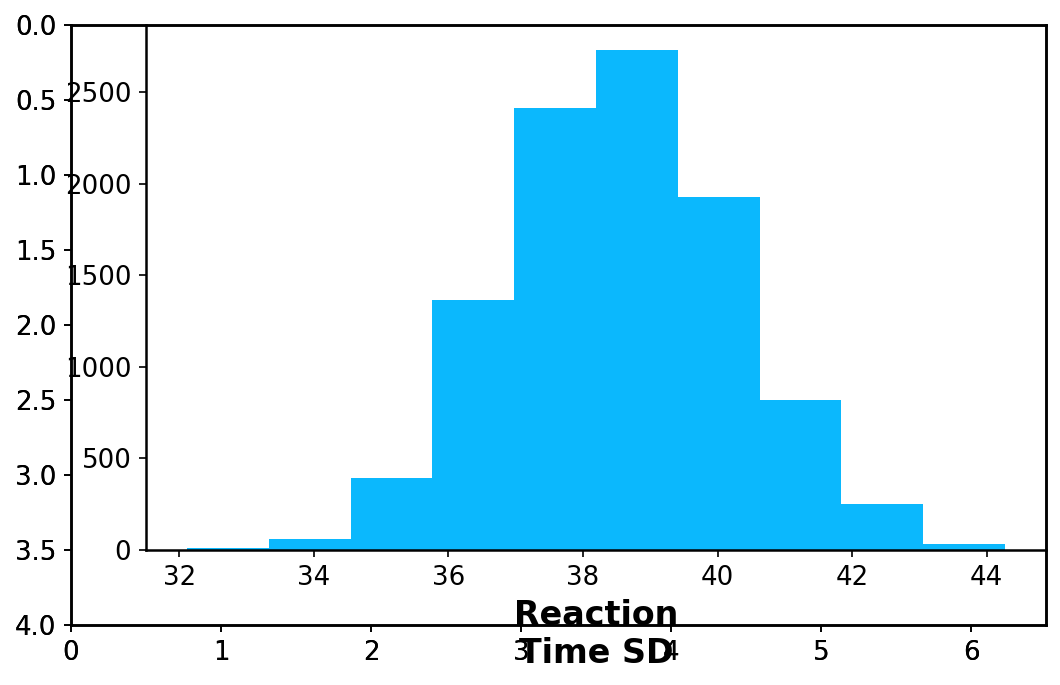

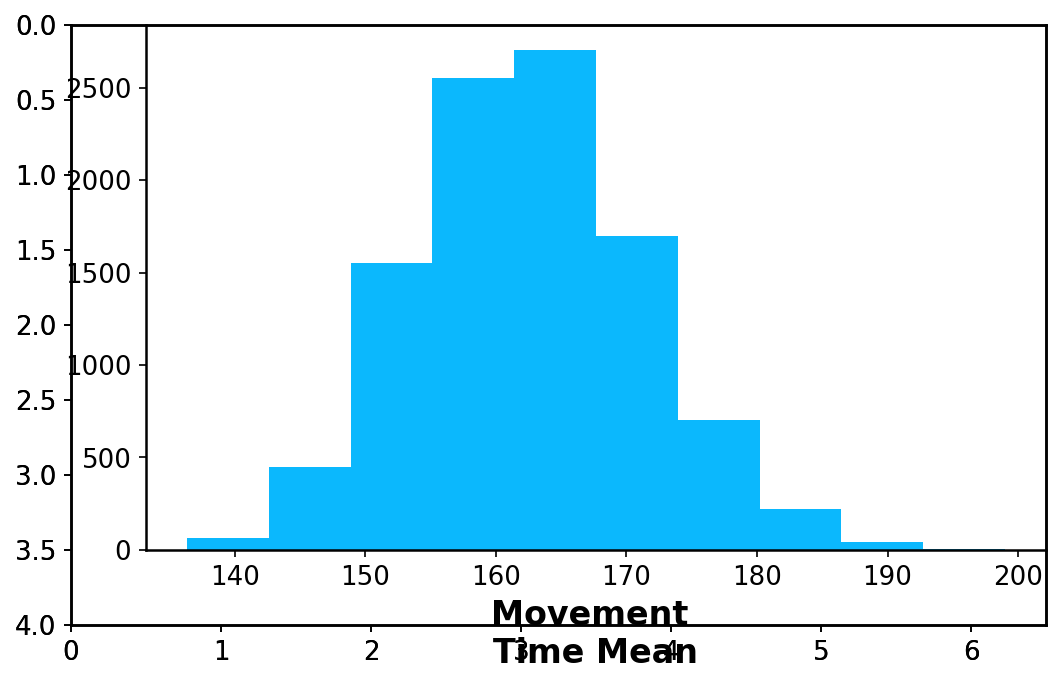

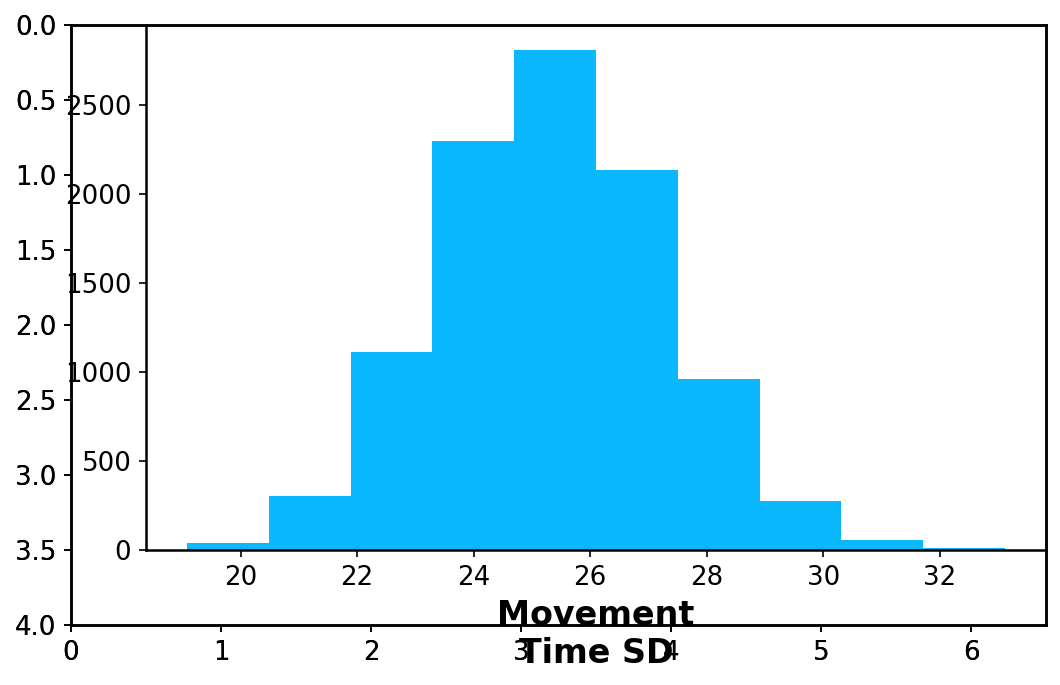

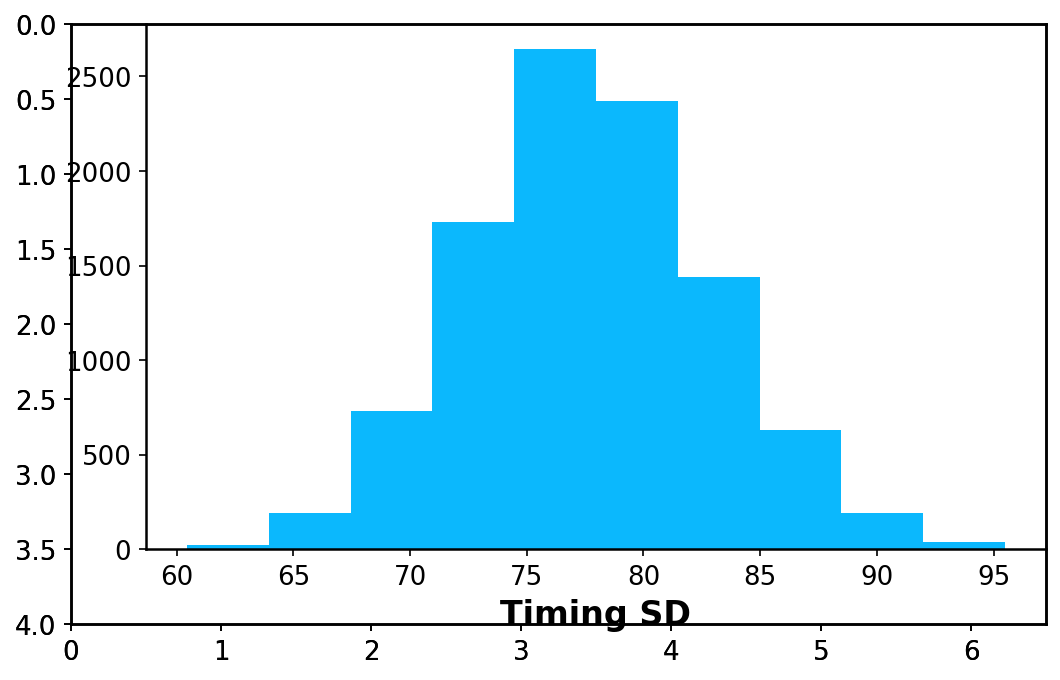

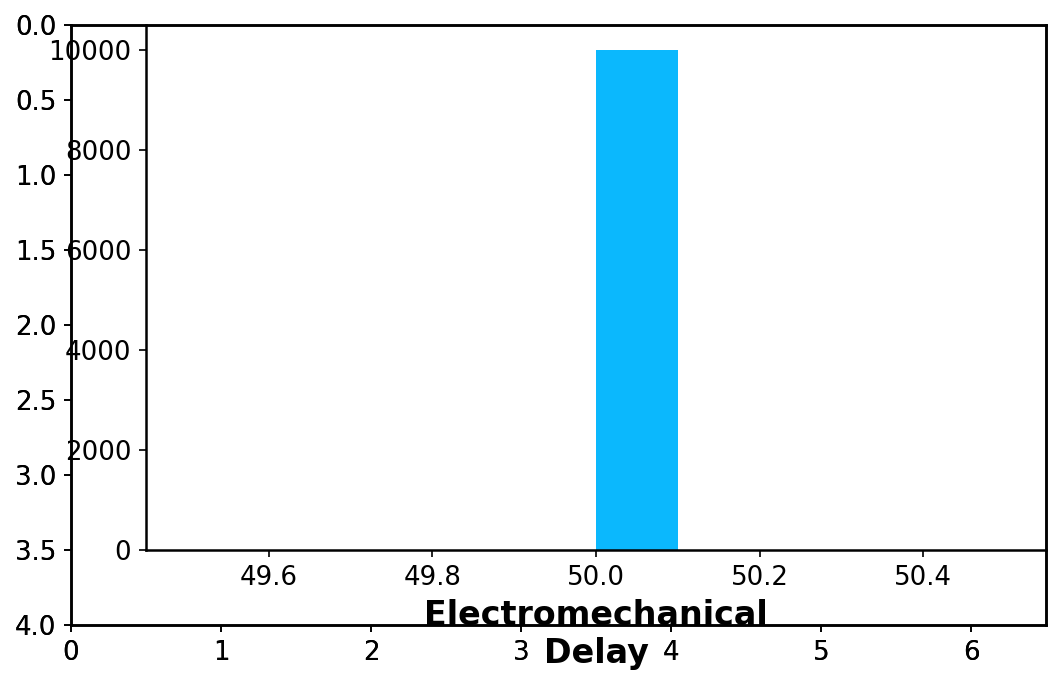

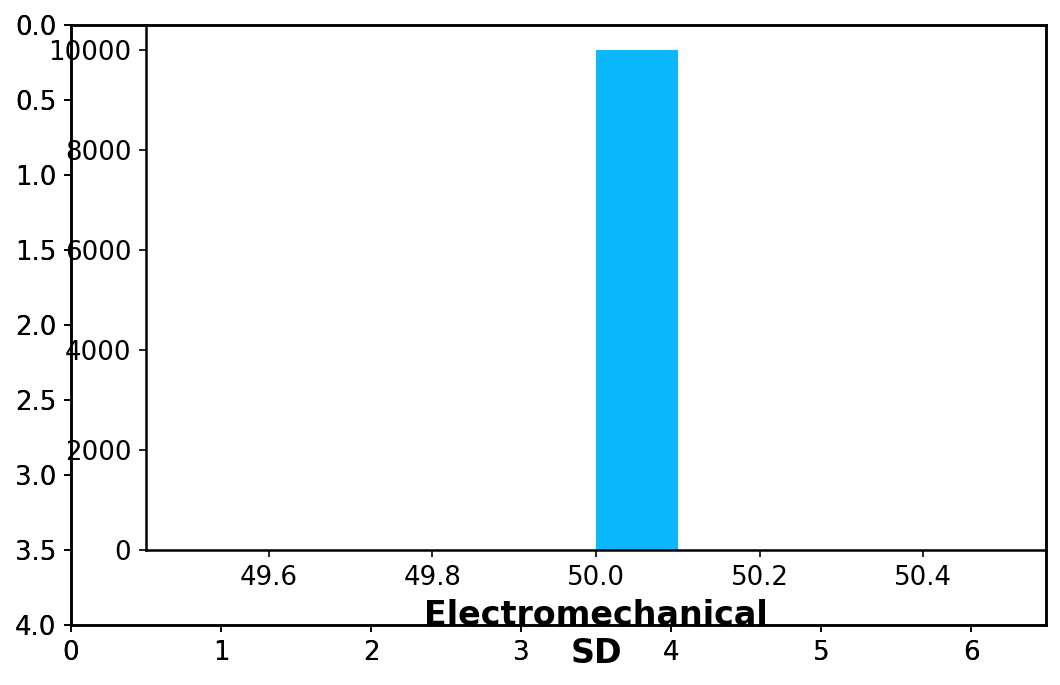

In [38]:
parameter_names = ['reaction_time', 'reaction_sd', 'movement_time',
                   'movement_sd','timing_sd','electromechanical_delay',
                   'electromechanical_sd']
for i,column in enumerate(parameter_columns):
    fig = dv.Figure()
    ax = fig.add_panel((0.5, 0, 6, 3.5))
    new_df = df_description.query(f"{column} == False")
    param_series = df_parameter[df_parameter['Model'].isin(new_df['Model'])][parameter_names[i]]
    if parameter_names[i] == "timing_sd":
        param_dist = np.stack(param_series).squeeze()[:,0,0]
    else:
        param_dist = np.stack(param_series).squeeze()[:,0]
    ax.set_xlabel(xticklabs[i])
    ax.hist(param_dist)

# Loss Distribution for each Parameter

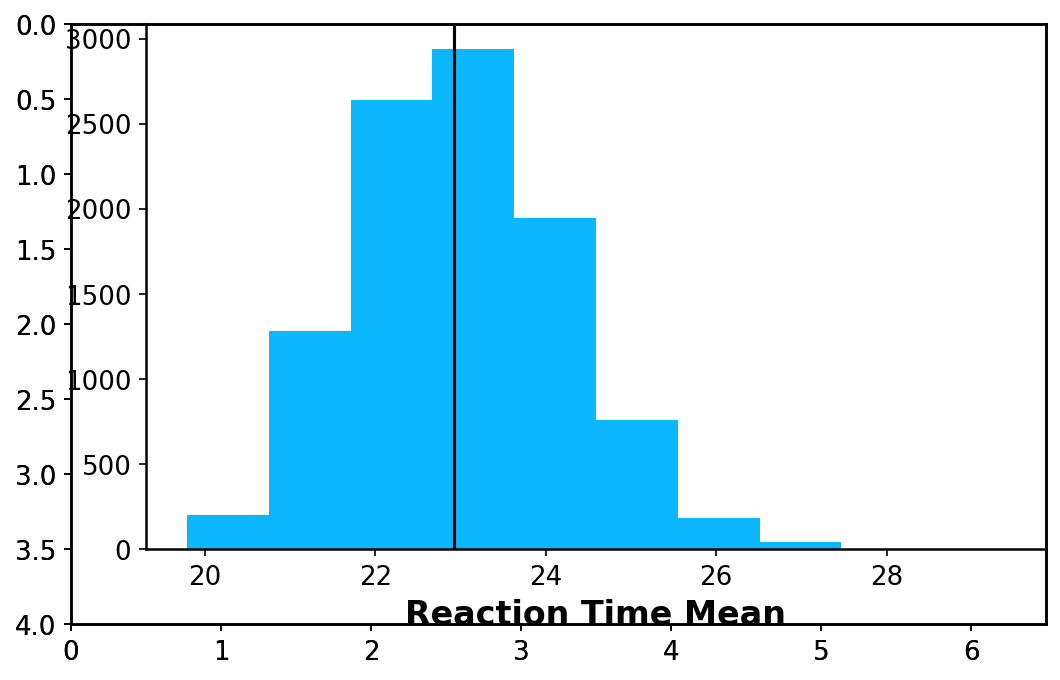

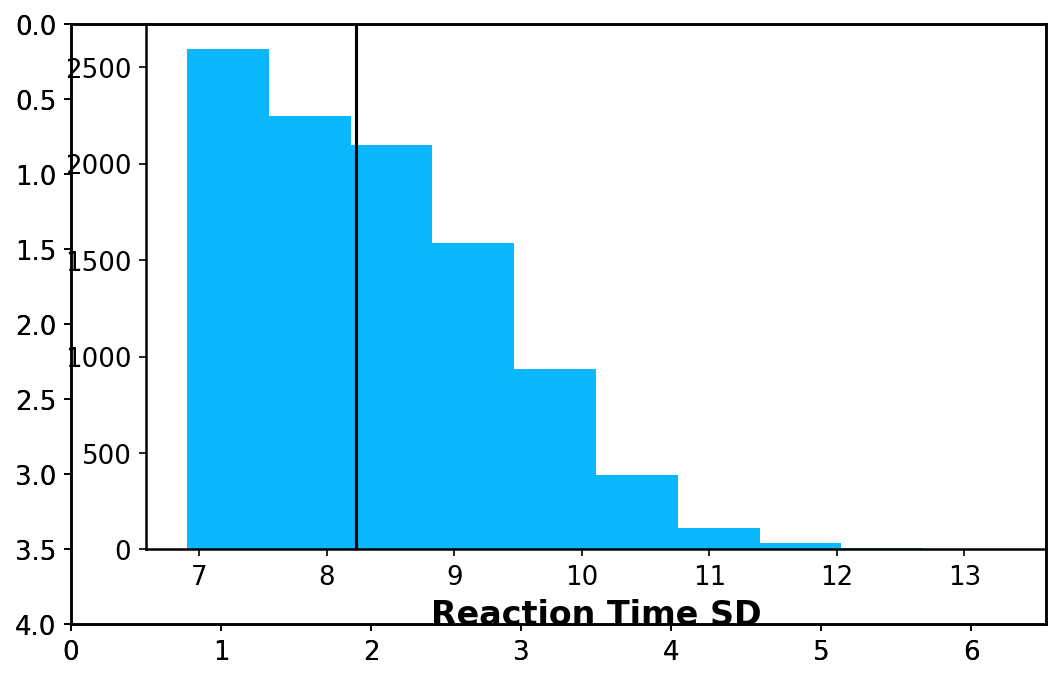

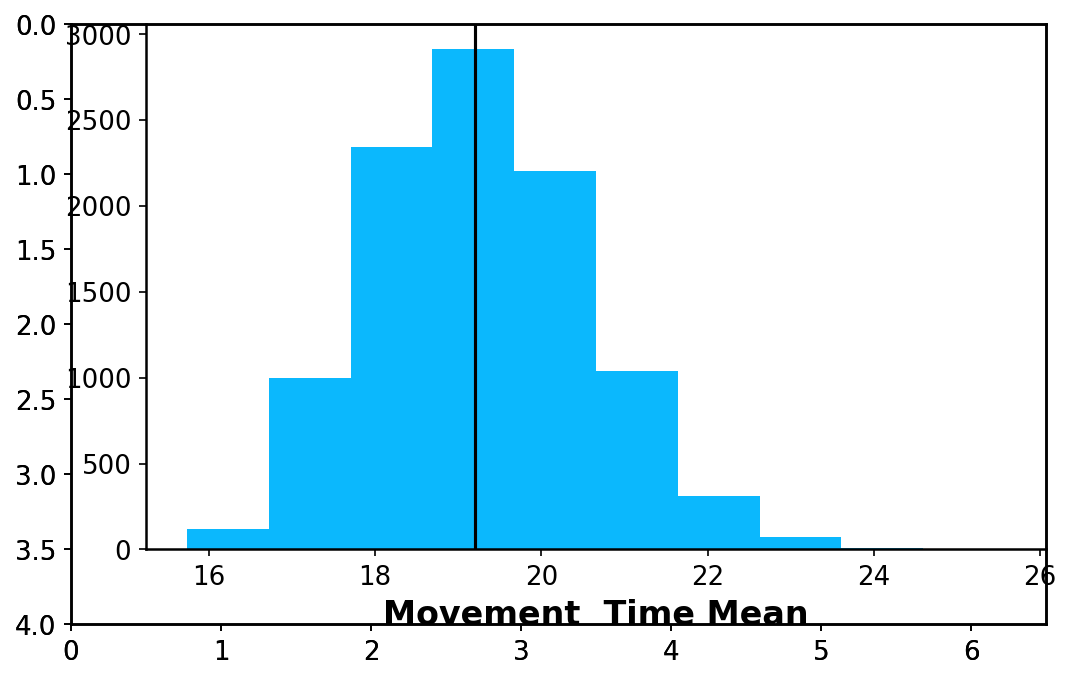

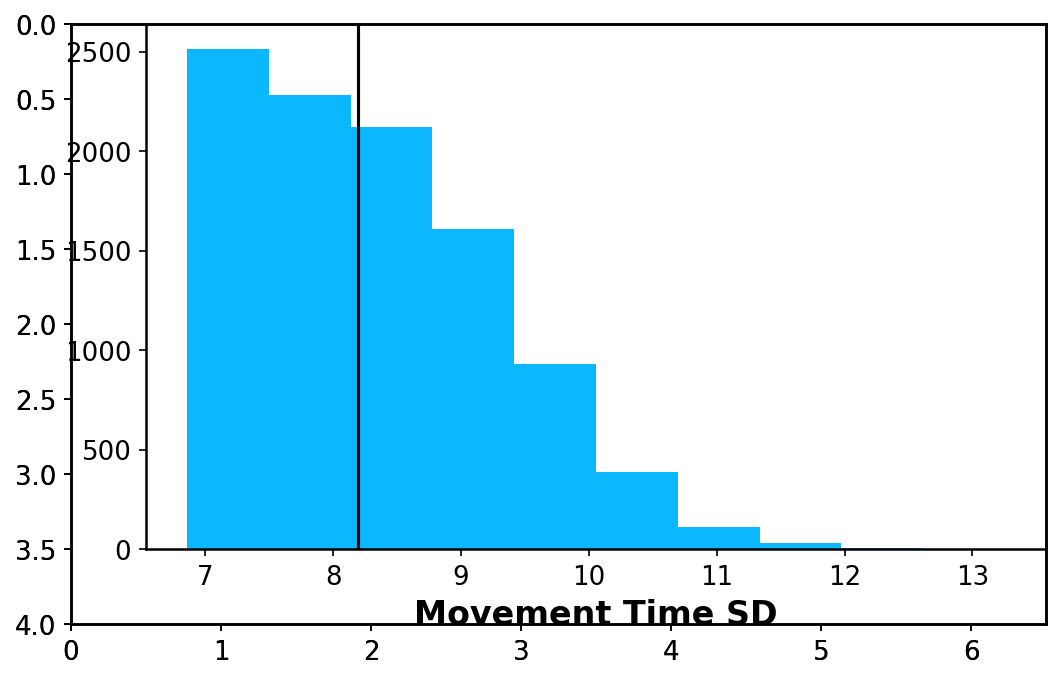

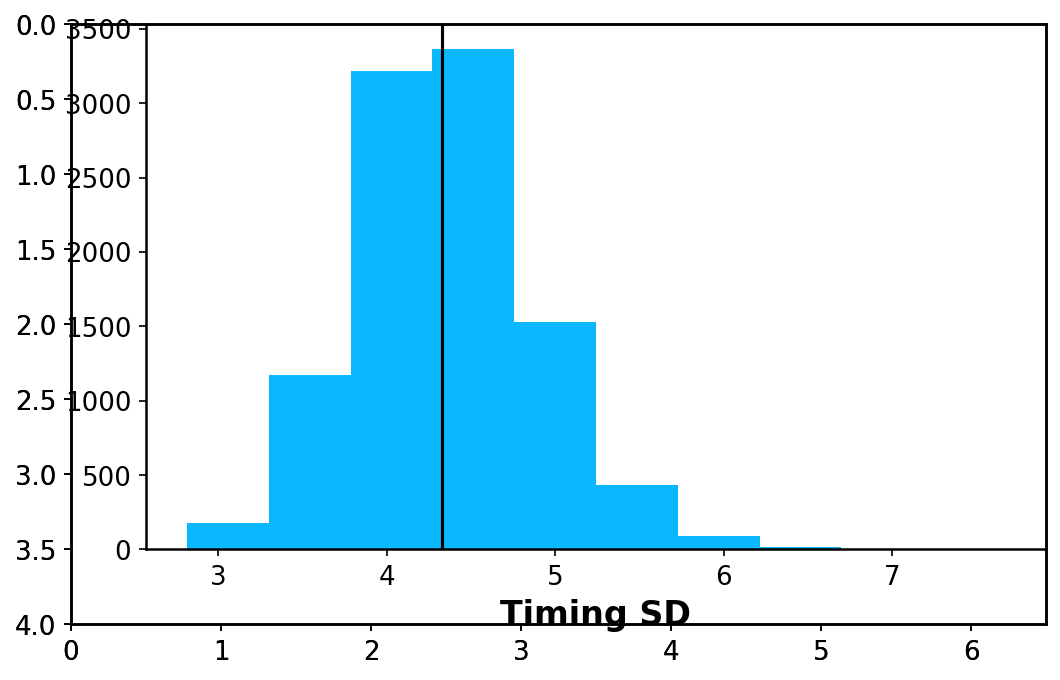

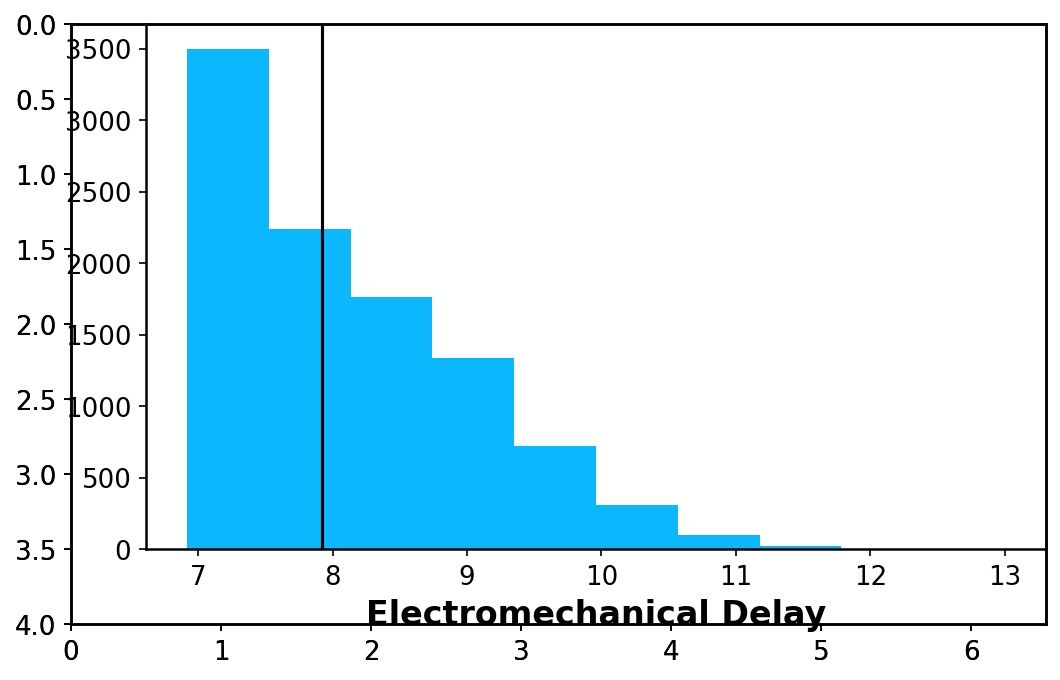

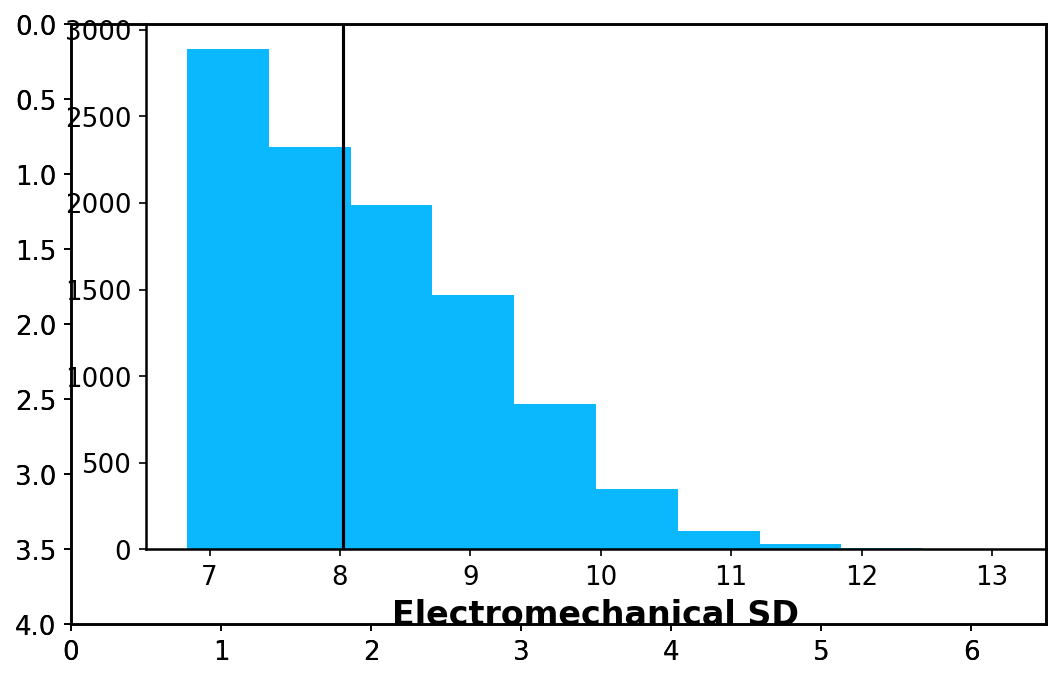

In [39]:
xticklabs = ["Reaction Time Mean", "Reaction Time SD",
             "Movement  Time Mean", "Movement Time SD",
             "Timing SD",
             "Electromechanical Delay", "Electromechanical SD"]
for i,column in enumerate(parameter_columns):
    fig = dv.Figure()
    ax = fig.add_panel((0.5, 0, 6, 3.5))
    new_df = df_description.query(f"{column} == False")
    median_loss = new_df['Loss'].median()
    ax.hist(new_df["Loss"])
    ax.axvline(median_loss)
    ax.set_xlabel(xticklabs[i])

# Plot models

Load data

In [40]:
#* Comparison Targets load
with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
    participant_median_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
    participant_sd_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
    participant_wins = dill.load(f)  
participant_perc_wins = (participant_wins/it.num_trials)*100
with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
    participant_incorrects = dill.load(f)  
participant_perc_incorrects = (participant_incorrects/it.num_trials)*100

with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
    participant_indecisions = dill.load(f)  
participant_perc_indecisions = (participant_indecisions/it.num_trials)*100

In [84]:
model_names_from_df = list(df_description.query('(Known_Timing_SD==False)')['Model'])
df = df_parameter[df_parameter['Model'].isin(model_names_from_df)]
one_row = df.iloc[0:1]
models = mhf.run_models_from_df(one_row)

In [80]:
one_row["guess_switch_sd"]

40000    [[[0]], [[0]]]
Name: guess_switch_sd, dtype: object

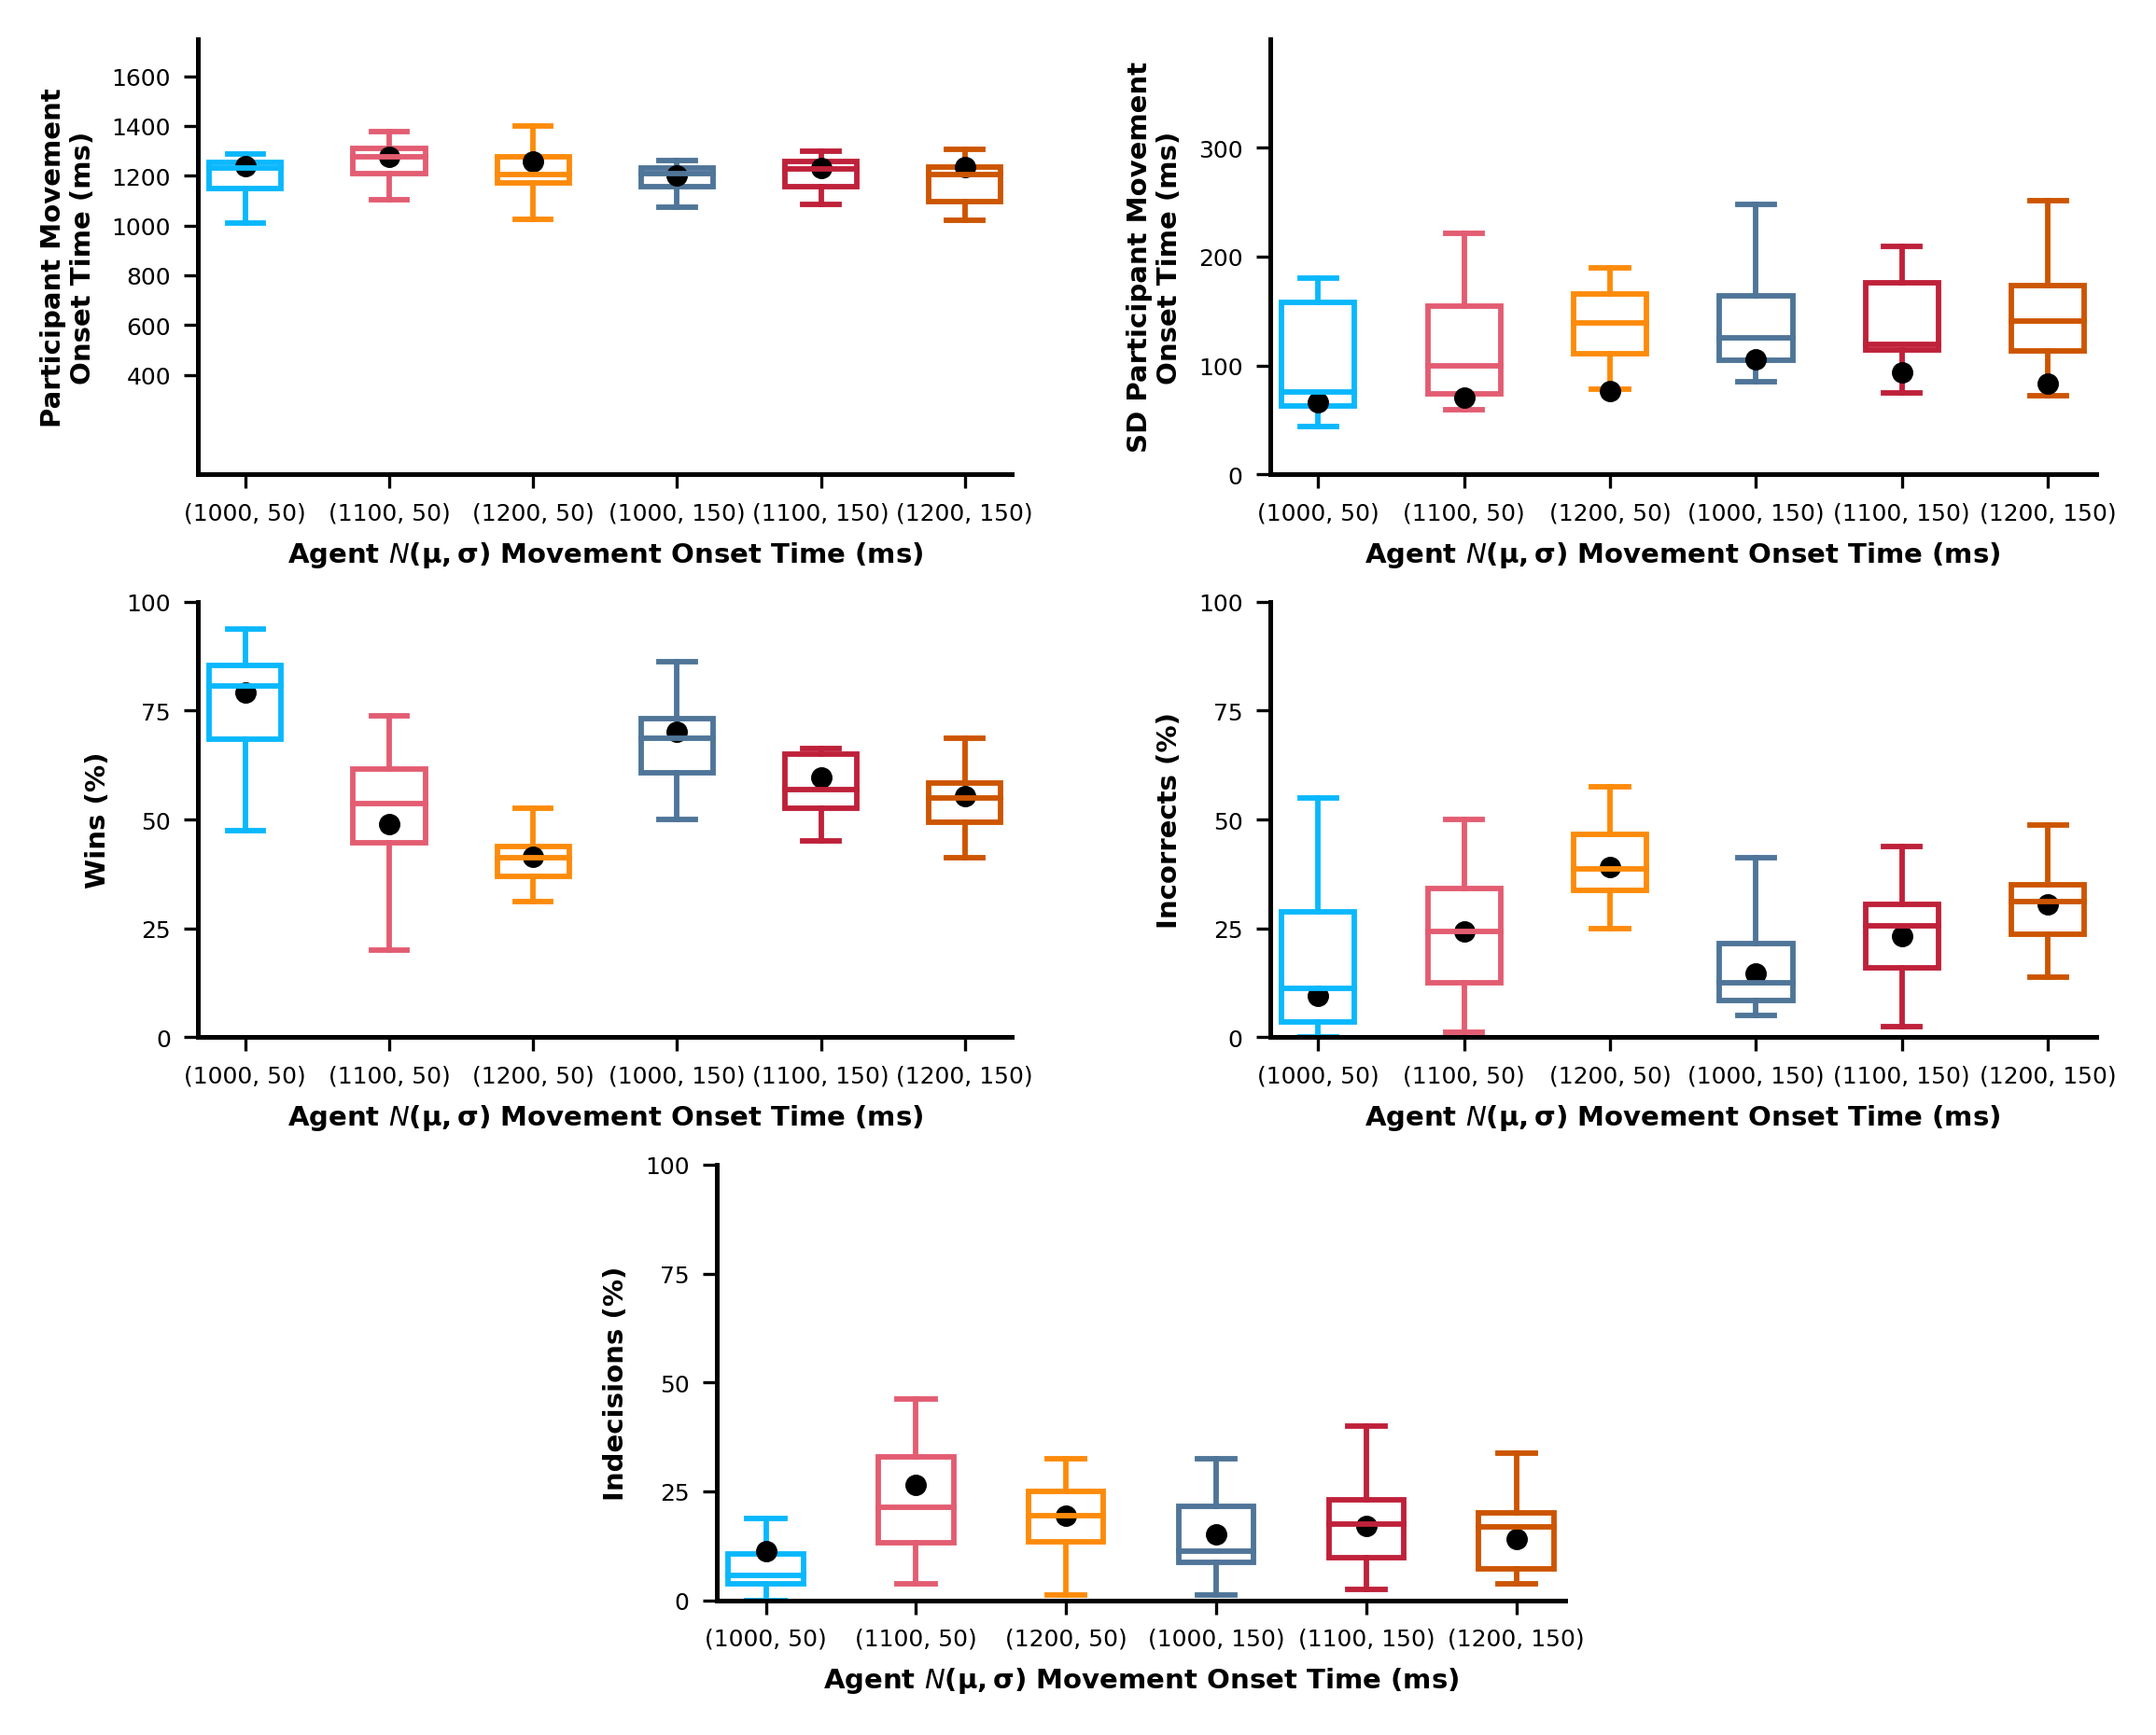

In [87]:
save_path = Path(
    r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures"
)
w, h = 7.5, 6
bw = (
    0.35 * w
) / it.num_blocks  # box widths of all boxes combined takes up 30% of the width
mult_w, div_w = 0.053, 2.3
div_h = 1.75
xlocs = np.linspace(0, w / div_w, num=len(it.trial_block_titles))
legend_fontsize = 5
ticklabel_fontsize = 6
suptitle_fontsize = 6
label_fontsize = 7
markersize = 0.1*(w*h)

metrics = np.array(
    [
        participant_median_movement_onset_time,
        participant_sd_movement_onset_time,
        participant_perc_wins,
        participant_perc_incorrects,
        participant_perc_indecisions,
    ]
)[:, :, [0, 2, 4, 1, 3, 5]] 
ylocs = [np.arange(400, 1601, 200), np.arange(0,400,100)] + [np.arange(0, 101, 25)] * 3
ylims = [(0, 1750)] + [(0, 400)] + [(0, 100)] * 3

xlocs = [0,1,2,3,4,5]
ylabels = [
    "Participant Movement\nOnset Time (ms)",
    "SD Participant Movement\nOnset Time (ms)",
    "Wins (%)",
    "Incorrects (%)",
    "Indecisions (%)",
]# titles = ["Median Movement Onset Time", "SD Movement Onset Time" "Wins", "Incorrects", "Indecisions"]
model_labels = [name.split("_")[0] for name in models.keys()]  # Get the model names, only up to the number, ignore date
mosaic = "aabb;ccdd;.ee."
fig = pf.NewFigure(mosaic, dpi=300, figsize=(w, h),wspace=None, hspace=None)
axs = list(fig.axes.values())
model_data = np.array([
    [model.results.get_metric(model.player_behavior.wtd_leave_time, metric_type="true", decision_type="optimal") for model in models.values()],
    [model.results.get_metric(model.player_behavior.wtd_leave_time_sd, metric_type="true", decision_type="optimal") for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_win, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_incorrect, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_indecision, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
]).squeeze()[:,[0, 2, 4, 1, 3, 5]] 

for i, ax in enumerate(axs):
    # * Looping each experimental condition
    for j in range(len(xlocs)):
        dv.boxplot(
            ax,
            xlocs[j],
            metrics[i, :, j],
            color=constants.xticklabel_colors_means[j],
            data_color=constants.xticklabel_colors_means[j],
            box_lw=1.4
        )
        
        pf.plot_boostrapped_model_results(
            ax,
            xlocs[j],
            y=model_data[i,j],
            percentiles=None,
            horizontal_lw=0,
            markersize=markersize,
            color=wheel.black,
                )
        ax.set_ylim(ylims[i])
        ax.set_xlim(min(xlocs) - 0.75*bw, max(xlocs) + 0.75*bw)
        ax.set_xticks(xlocs, labels=constants.xticklabels, fontsize=ticklabel_fontsize)
        ax.set_yticks(ylocs[i], labels=ylocs[i], fontsize=ticklabel_fontsize)
        ax.set_xlabel(it.xlabel, fontsize=label_fontsize)
        ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
        # dv.legend(ax, labels=model_labels, colors=model_colors,fontsize=legend_fontsize)
fig.remove_figure_borders()
# plt.suptitle(suptitles[i], y=1.1, fontsize = 30)

In [71]:
model_data.shape[:,[0, 2, 4, 1, 3, 5]] 

(5, 6)

In [77]:
np.sqrt(60**2 + 70**2)

92.19544457292888

In [46]:
model_data = [
    [model.results.get_metric(model.player_behavior.wtd_leave_time, metric_type="true", decision_type="optimal") for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_win, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_incorrect, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_indecision, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
]
model_data

[[array([1216.32400722, 1166.13332533, 1222.16062714, 1178.35502997,
         1167.9680039 , 1156.66589919])],
 [array([80.01755271, 71.56445758, 52.00308728, 62.27497523, 46.2878283 ,
         58.92460086])],
 [array([10.42877681, 16.19303985, 27.34466069, 25.69607736, 43.73177616,
         33.21452625])],
 [array([ 9.55367048, 12.24250257, 20.65225203, 12.02894741,  9.98039554,
          7.86087289])]]